#Jonas Tollofsen, Rikard Larsson, Raees Khan & Christian Ulehla

## Exercise 5 - Text Classification using pre-trained models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.datasets import AG_NEWS
import torchtext
import matplotlib.pyplot as plt
import numpy
import random
import gensim
from sklearn.metrics import confusion_matrix, f1_score
from gensim.models import KeyedVectors
import gensim.downloader as api

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

False
cpu


## 1. Setting up the data


In [ ]:
!pip install torchtext==0.8.1 ##requires torchtext 0.8.1 to run

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user


#### AG News dataset

In [ ]:
## Download,tokenize, and index the AG News dataset
# This is done in a separate cell as indexing takes some time

ag_train, ag_test = AG_NEWS(ngrams=1, vocab=None, root='.')

ag_news_csv.tar.gz: 100%|██████████| 11.8M/11.8M [00:00<00:00, 24.2MB/s]
120000lines [00:05, 20933.93lines/s]
120000lines [00:11, 10876.41lines/s]
7600lines [00:00, 10909.06lines/s]


In [ ]:
# Our labels are numbers, here's what type of article they represent
ag_labels = {
    0 : 'World',
    1 : 'Sports',
    2 : 'Business',
    3 : 'Sci/Tec'
}

# vocab is a class that will give us the index for any given word/token (vocab['hi'] = <some number>)
vocab = ag_train.get_vocab()

# nr2word is a list that contains the actual tokens for a given index (nr2word[5678] = <some word/token>)
nr2word = vocab.itos
num_classes = len(ag_labels)

# Let's make a function that takes an entire tensor and returns the string version of that tensor
def tensor2text(tensor):
    return ' '.join([nr2word[index] for index in tensor])

# And a function to turn text into the indexed version (though it won't work with special characters)
def text2tensor(text):
    tensor = torch.Tensor([vocab[token] for token in text.split(' ')])
    return tensor.int()

## Bag of Words (BoW)


In [ ]:
def bow_embedder(tensor, vocab_length):
    tensor = tensor.long()
    embedding = torch.zeros(vocab_length)
    for x in tensor:
        embedding[x] += 1
    return embedding

### Training a news text classifier

### Exercise 1: Create a neural network and the train and test loops, and get at least 80% accuracy on the test set.

In [ ]:
# We create our own dataset to load the BoW embedded texts
class BoWDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, embedder):
        self.dataset = dataset
        self.embedder = embedder
        
    def __getitem__(self, index):
        return self.dataset[index][0], self.embedder(self.dataset[index][1], len(vocab))
  
    def __len__(self):
        return len(self.dataset)

In [ ]:
# Set up the train and test data using our custom BoWDataset and the DataLoader class
bow_train_data = BoWDataset(ag_train, bow_embedder)
bow_test_data = BoWDataset(ag_test, bow_embedder)
bow_trainloader = DataLoader(bow_train_data, batch_size=1000, shuffle=True)
bow_testloader = DataLoader(bow_test_data, batch_size=1000, shuffle=False)

In [ ]:
#Define ANN
network = nn.Sequential(
    nn.Linear(
        in_features=len(vocab), ## amount of neurons in the input layer is equal to the size of our vocabulary
        out_features= 50,
        bias=True,
    ),

    nn.ReLU(),

    nn.Linear(
        in_features=50,## 50 neurons in previous hidden layer
        out_features=num_classes,
        bias=True
    ),

    nn.Sigmoid(),
).to(device) ##pushes NN to the current device (GPU or CPU)


In [ ]:
optimizer = torch.optim.Adam(network.parameters()) #Adam is a good standard for optimizers, used widely so a good baseline
loss_function = nn.CrossEntropyLoss()
epochs = 3

#Run training
for epoch in range(epochs):
    # For each batch of data (since the dataset is too large to run all data through the network at once)
    for batch_nr, (labels, data) in enumerate(bow_trainloader):

      data = data.to(device)
      labels = labels.to(device)

      optimizer.zero_grad #zero the gradients, this ensure that pytorch can correctly calculate the gradients for the current epoch, as the old gradients will stick around 

      outputs = network(data) ## network makes predictions on the data in the mini batch (1000 examples per batch)
      loss = loss_function(outputs, labels) ## calculates the loss based on the networks prediction vs the labels (i.e how bad / good did the network perform)

      loss.backward() ## performs backpropagation
      optimizer.step() #updates the weights based on the gradients

      print(f'\rEpoch {epoch+1} [{batch_nr+1}/{len(bow_trainloader)}] - Loss: {loss}',end='')

Epoch 3 [120/120] - Loss: 0.8122487664222717

We should analyse the performance of our network besides the loss. Let's calculate the accuracy and the confusion matrix.

In [ ]:
with torch.no_grad(): ## torch.no_grad tells pytorch to not calculate any gradients as pytorch will calculate gradients for each Tensor that has the argument .requires_grad set to True, which our Tensors do have 
    classes = [0, 1, 2, 3]
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    # For each batch of testing data (since the dataset is too large to run all data through the network at once)
    # Calculate the accuracy
    for batch_nr, (labels, data) in enumerate(bow_testloader):
        labels = labels.to(device)
        data = data.to(device)
        prediction = network(data)
        prediction = torch.argmax(prediction, dim=-1)
        correct += sum(prediction==labels).item()
        total += len(labels)
        for pred in prediction:
            y_pred.append(pred.to('cpu'))
        for label in labels:    
            y_true.append(label.to('cpu'))
            
    print(f'The accuracy of the network is {str(100*correct/total)[:4]}%.')
    

The accuracy of the network is 89.5%.


Accuracy is roughly 90%, which is pretty good! we can surely increase this a bit with a more complex model as this one is rather simple

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

F1 score on the test set:
0.8954833250396007
Confusion matrix, without normalization
[[1703   60  107   30]
 [  12 1855   32    1]
 [  47   11 1763   79]
 [  84   22  307 1487]]


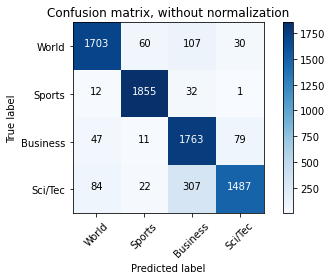

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1, 2, 3])
numpy.set_printoptions(precision=2)
print('F1 score on the test set:')
print(f1_score(y_true, y_pred, average = 'weighted'))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['World', 'Sports', 'Business', 'Sci/Tec'],
                      title='Confusion matrix, without normalization')

the network struggles mostly with differentiating between Business & Sci/Tec, this is an area where we can probably improve and which we should focus on to create a better model

# Exercise 2: Training a FFNN with w2v

In [ ]:
wv = api.load('word2vec-google-news-300')

In [ ]:
# We create our own dataset to load the w2v embedded texts
class w2vDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, embedder):
        self.dataset = dataset
        self.embedder = embedder
        
    def __getitem__(self, index):
        return self.dataset[index][0], self.embedder(self.dataset[index][1], 300)
  
    def __len__(self):
        return len(self.dataset)

##**Exercise 2.1 & 2.3:** Create a w2v-embedder using our pre-trained w2v model and handle OOV and varying input length.

In [ ]:
def w2v_embedder(tensor, embedding_length):
    tensor = tensor.long()

    embedding = torch.zeros(embedding_length) # initializes the size of the embedding to be the same size as wv which is 300
    
    #iterates over each token in the text that was sent in through the argument "tensor"
    for token in tensor:
        try:
            embedding += wv[nr2word[token]] ## translates the word index to the actual word and then gets the embedding for that word
        except:
            embedding += torch.zeros(embedding_length) ##If the word is OOV we just skip it, i.e we add 0 to the embeddings 
    
    embedding = embedding / len(tensor) # divide embedding by the amount of words in the tensor, this ensures that a longer sentences doesn't overpower shorter sentences
    return embedding

##**Exercise 2.2:** Describe three possible ways to deal with OOV-words and varying sentence length. What are the benefits and drawbacks of the methods you have described?

###1 - FastText

fastText is a library for text classification and word embeddings. It was created by (FAIR) Facebook's AI Research lab. The model can be used to create a supervised / unsupervised learning algorithm for obtaining vector representations for words.

Benefits:

- fastText has some benefits over other algorithms used for word embedding. It 
treats a word as consisting of n-grams of characters in comparisons of other word vectors such as Word2Vec which handles every word as the smallest unit and finds vector representation for every word. By character representation of a word, fastText can find vector representation for rare words. Rare words can be broken into character n-grams. These characters could share the n-grams with the common words. So, this technique is helpful in managing vector representation for words absent in dictionary (rare words). Character n-grams embeddings tend to outperform GloVe  and Word2Vec on smaller datasets (Bojanowski et al., 2017).
- FastText has all the advantages of the Word2Vec process and improve the accuracy as well.
- fastText is created with the goal to be an efficient CPU tool so that models could be trained without needing a GPU.
- Works on many languages: FastText pretrained language model has support for 176 different languages.
- It is an open-source, lightweight library and models can later be reduced to fit small devices e.g., mobile phones.
- Another advantage is that it supports training continuous bag of words (CBOW) or Skip-gram models

Drawback:

- As we know that any model has pros and cons and fastText is no exception. One major drawback of this model is high memory requirement for an obvious reason that fastText model creates word-embedding from its characters instead of words. Though character embeddings can be controlled by using the maximum and minimum n-grams.
- Although it brings additional utility to the embeddings, fastText also significantly slows down the process.
- Comparatively, it takes longer time to train a FastText model (number of n-grams > number of words)
- Currently fastText only works on CPU.

References:
Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). Enriching word vectors with subword information. Transactions of the Association for Computational Linguistics, 5, 135–146.

## ELMO 

Benefits:

ELMO which stands for “Embeddings from Language Model” (Peters et al., 2017) is another popular framework used for word embedding, developed at the Allen Institute for AI.
•	ELMO addresses the issue that a same word can have different meaning, depending on the context. For example, let’s consider the word “stick” in the following two sentences:
→	“Can you fetch me the stick?”
→	“We will stick to our plan”
Here using Word2Vec and GloVe word embeddings will generate the same meaning. This drawback has been addressed by the ELMO and will create different word vector based on the context used.
•	ELMO uses bi-directional LSTM language model, which not only enable ELMO in understanding the next words but also the preceding ones.
•	As noted above, ELMO like Word2Vec model, can predict the next likely word in the sentence. And if trained on a massive dataset, ELMO can recognize language pattern.
•	Another characteristic that distinguishes ELMO from other traditional frameworks is that ELMO uses character embedding to map tokens to a representation.
•	Since LSTM network is used internally in ELMO, so only those OOV or rare words needs to be handled that are absent from the training dataset dictionary as ELMO creates character embeddings too which enables the network to use morphological clues for rare words tokens unnoticed in training.
•	ELMO model generates vector representation on the fly i.e., at runtime.

Drawbacks:

•	One disadvantage of ELMO model is that though it takes into account the context of a particular word and generate two separate vectors, it simply concatenates the left-to-right and right-to-left information. Due to this, ELMO cannot take advantage of both left and right contexts concurrently. The good thing is that BERT has addressed this drawback of ELMO and looks all the words simultaneously.

References:
Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). Enriching word vectors with subword information. Transactions of the Association for Computational Linguistics, 5, 135–146.
Peters, M. E., Ammar, W., Bhagavatula, C., & Power, R. (2017). Semi-supervised sequence tagging with bidirectional language models. ArXiv Preprint ArXiv:1705.00108.
 





##**Exercise 2.4**: Build a model that takes w2v-ecnodings of the AG-NEWS dataset as inputs and outputs AG-NEWS classes.


In [ ]:
w2v_train_data = w2vDataset(ag_train, w2v_embedder)
w2v_test_data = w2vDataset(ag_test, w2v_embedder)
w2v_trainloader = DataLoader(w2v_train_data, batch_size=2000, shuffle=True, pin_memory=True)
w2v_testloader = DataLoader(w2v_test_data, batch_size=1000, shuffle=False)

embedding_length = 300  

In [ ]:
#Define ANN
network_w2v = nn.Sequential(
    nn.Linear(
        in_features=embedding_length, ## amount of neurons in the input layer is equal to the embedding length, i.e 300
        out_features= 100,
        bias=True,
    ),

    nn.ReLU(),

    nn.Linear(
        in_features=100,## 100 neurons in previous layer
        out_features=50,
        bias=True
    ),

      nn.ReLU(),

    nn.Linear(
        in_features=50,## 50 neurons in previous layer
        out_features=num_classes,
        bias=True
    ),

    nn.Sigmoid(),
).to(device) ## push NN to device (GPU or CPU)

In [ ]:
optimizer = torch.optim.Adam(network_w2v.parameters())
loss_function = nn.CrossEntropyLoss()

epochs = 2

for epoch in range(epochs):
    # For each batch of data (since the dataset is too large to run all data through the network at once)
    for batch_nr, (labels, data) in enumerate(w2v_trainloader):
      labels = labels.to(device)
      data = data.to(device)

      optimizer.zero_grad #zero the gradients, this ensure that pytorch can correctly calculate the gradients for the current epoch, as the old gradients will stick around 
      outputs = network_w2v(data) ## network makes predictions on the data in the mini batch (1000 examples per batch)
      loss = loss_function(outputs, labels) ## calculates the loss based on the networks prediction vs the labels (i.e how bad / good did the network perform)
      loss.backward() ## performs backpropagation
      optimizer.step() #updates the weights based on the gradients

      print(f'\rEpoch {epoch+1} [{batch_nr+1}/{len(w2v_trainloader)}] - Loss: {loss}',end='')

Epoch 2 [60/60] - Loss: 0.9844510555267334

Let's once again calculate accuracy and the confusion matrix.

In [ ]:
with torch.no_grad():
    classes = [0, 1, 2, 3]
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    # For each batch of testing data (since the dataset is too large to run all data through the network at once)
    # Calculate the accuracy, precision and recall
    for batch_nr, (labels, data) in enumerate(w2v_testloader):
        labels = labels.to(device)
        data = data.to(device)
        prediction = network_w2v(data)
        prediction = torch.argmax(prediction, dim=-1)
        correct += sum(prediction==labels).item()
        total += len(labels)
        for pred in prediction:
            y_pred.append(pred.to('cpu'))
        for label in labels:    
            y_true.append(label.to('cpu'))
            
    print(f'The accuracy of the network is {str(100*correct/total)[:4]}%.')

The accuracy of the network is 82.0%.


F1 score on the test set:
0.8221255889967641
Confusion matrix, without normalization
[[1625   53  148   74]
 [ 115 1630   11  144]
 [ 111    8 1435  346]
 [  95   14  244 1547]]


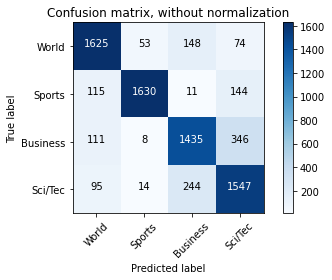

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1, 2, 3])
numpy.set_printoptions(precision=2)
print('F1 score on the test set:')
print(f1_score(y_true, y_pred, average = 'weighted'))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['World', 'Sports', 'Business', 'Sci/Tec'],
                      title='Confusion matrix, without normalization')

#The network might not converge towards good performance depending on your solutions to 2.3. Why?

The above network using word embeddings doesnt perform as good as the Feedforward network using BoW, but it still performs acceptable with an accuracy of 82%. This could probably be due to the fact that, even though we use word embeddings in this network, we basically just "squished" the whole sentence into a dense vector of 300 values, whereas the BoW implementation was sparse, but in that case still contained all the information. Essentially the only difference between the first NN and this one is that we took the sparse vector representaiton and squished it down into a vector of size 300 in an attempt to represent the same information.

Although one thing that both of these implementations are lacking is the positional aspect of words, i.e where do we place each word? both the BoW and embedding version above does not take the placement of words into consideration, which RNNs can help us deal with below.

# 3. Recurrent Neural Networks

In [ ]:
# We create our own dataset to load the w2v embedded texts
class rnnDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, embedder):
        self.dataset = dataset
        self.embedder = embedder
        
    def __getitem__(self, index):
        return self.dataset[index][0], self.embedder(self.dataset[index][1], 300)
  
    def __len__(self):
        return len(self.dataset)

##**Exercise 3.1:** Implement an emedder for rnnDataset which takes an input tensor, transforms it to words->tokens->embeddings, then stores the embeddings while maintainin the structural integrity of the original sentences. <br>

In [ ]:
def rnn_embedder(tensor, embedding_length=300):
    tensor = tensor.long()
    words = []

    for token in tensor:
      embedding = torch.zeros(embedding_length)
      try:
        embedding = wv[nr2word[token]]
                       
      except:
        continue
    
      words.append(embedding) ##appends each word as a vector in order of occurence

    return torch.Tensor(words) ##converts the list to a tensor

In [ ]:
test = rnn_embedder(ag_train[4][1])
test

tensor([[-0.1396,  0.0623, -0.2793,  ...,  0.2041,  0.2354, -0.0510],
        [-0.0261, -0.1113, -0.2637,  ...,  0.0244,  0.3301, -0.1133],
        [ 0.1216,  0.0352, -0.3418,  ...,  0.0117,  0.1367, -0.0742],
        ...,
        [ 0.0299,  0.0564,  0.0037,  ..., -0.0242,  0.0109, -0.1475],
        [-0.1201,  0.1826, -0.0044,  ..., -0.0312, -0.1050,  0.2734],
        [-0.0415,  0.0598, -0.1250,  ..., -0.0033, -0.1260,  0.1777]])

**Exercise 3.2:** Finish the implementation of our LSTM network class.

In [ ]:
from torch.autograd import Variable 

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #nr of classes
        self.num_layers = num_layers #nr of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc_1 =  nn.Linear(hidden_size, 64, bias=True) #First FC layer
        self.fc = nn.Linear(64, num_classes, bias=True) # Final FC layer
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out


In [ ]:
num_epochs = 2 #2 epochs
learning_rate = 0.001 #0.001 lr

# STUDENTCODE:
## TASK: Insert the correct dimensions for our LSTM and FC layers by looking at the documentation for LSTM
hidden_size = 100 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
embedding_length = 300
num_classes = 4

lstm1 = LSTM1(num_classes=num_classes, input_size=embedding_length, hidden_size=hidden_size, 
              num_layers=num_layers) #our lstm class

In [ ]:
lstm1

LSTM1(
  (lstm): LSTM(300, 100, batch_first=True)
  (fc_1): Linear(in_features=100, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
)

Using our LSTM class and RNN dataloader, let's train out network and see how well it works.

**Exercise 3.3:** Train the network to reach an accuracy of over 90%. <br>
**Hint:** Consider starting with batch size = 1 or else data will have multiple sequence lengths. <br>
Use torch.from_numpy to convert a numpy array to torch

In [ ]:
optimizer_lstm = torch.optim.Adam(lstm1.parameters())
loss_function = nn.CrossEntropyLoss()

rnn_train_data = rnnDataset(ag_train, rnn_embedder)
rnn_test_data = rnnDataset(ag_test, rnn_embedder)
rnn_trainloader = DataLoader(rnn_train_data, batch_size=1, shuffle=True)
rnn_testloader = DataLoader(rnn_test_data, batch_size=1, shuffle=False)

In [ ]:
for epoch in range(num_epochs):
    for batch_nr, (labels, data) in enumerate(rnn_trainloader):

        outputs = lstm1.forward(data)
        optimizer.zero_grad #zero the gradients, this ensure that pytorch can correctly calculate the gradients for the current epoch, as the old gradients will stick around 

        loss = loss_function(outputs, labels)## calculates the loss based on the networks prediction vs the labels (i.e how bad / good did the network perform)
      
        loss.backward() ## performs backpropagation
        optimizer.step() #updates the weights based on the gradients

        if batch_nr % 50 == 0:
          print(f'\rEpoch {epoch+1} [{batch_nr+1}/{len(rnn_trainloader)}] - Loss: {loss}',end='')

    

Epoch 2 [119951/120000] - Loss: 1.426784634590149

Let's once again calculate accuracy and the confusion matrix.
Calculate accuracy and confusion matrix. How well does your network perform? What could you do to improve accuracy further (you don't have to implement this)

In [ ]:
with torch.no_grad():
    classes = [0, 1, 2, 3]
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    # For each batch of testing data (since the dataset is too large to run all data through the network at once)
    # Calculate the accuracy, precision and recall
    for batch_nr, (labels, data) in enumerate(rnn_testloader):
        prediction = lstm1(data)
        prediction = torch.argmax(prediction, dim=-1)
        correct += sum(prediction==labels).item()
        total += len(labels)
        for pred in prediction:
            y_pred.append(pred)
        for label in labels:    
            y_true.append(label)
            
    print(f'The accuracy of the network is {str(100*correct/total)[:4]}%.')

The accuracy of the network is 25.0%.


F1 score on the test set:
0.1
Confusion matrix, without normalization
[[   0 1900    0    0]
 [   0 1900    0    0]
 [   0 1900    0    0]
 [   0 1900    0    0]]


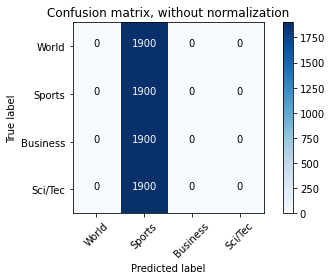

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1, 2, 3])
numpy.set_printoptions(precision=2)
print('F1 score on the test set:')
print(f1_score(y_true, y_pred, average = 'weighted'))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['World', 'Sports', 'Business', 'Sci/Tec'],
                      title='Confusion matrix, without normalization')